## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import json
import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import librosa
from hparams import create_hparams
from model import Tacotron2, VAE
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from utils import load_wav_to_torch, to_gpu
from glow import WaveGlow

/home/eugene/tacotron2-pytorch/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/eugene/anaconda3/envs/taco

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
# hparams.sampling_rate = 24000


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [52]:
# checkpoint_path = "tacotron2_statedict.pt"
# checkpoint_path = 'checkpoint_15000'
# checkpoint_path = 'spanish_checkpoints/checkpoint_19000'
checkpoint_path = 'libritts_checkpoints/checkpoint_121000'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels.pt'
waveglow_config_path = 'waveglow/config.json'
with open(waveglow_config_path) as f:
    data = f.read()
config = json.loads(data)
waveglow_config = config["waveglow_config"]

# waveglow = torch.load(waveglow_path)['model']
model_state_dict = torch.load(waveglow_path)['model'].state_dict()
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(model_state_dict)

waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/eugene/anaconda3/envs/tacotron-pytorch/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'glow.Invertible1x1Conv' has changed. 

#### Prepare text input

In [58]:
# text = "Waveglow is really awesome!"
text = "Hello"
# text = "buenas tardes"
sequence = np.array(text_to_sequence(text, ['spanish_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long() 

#### Infer speaker info

In [59]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

In [60]:
def get_mel(filename):
    audio, sampling_rate = load_wav_to_torch(filename, hparams.sampling_rate)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, hparams.sampling_rate))
#     audio_norm = audio / hparams.max_wav_value
    audio_norm = audio.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0)
    return melspec

In [66]:
# audio = '/mnt/data/corpora/LibriTTS/dev-clean/3000/15664/3000_15664_000020_000007.wav'
audio = '/mnt/data/corpora/LJSpeech-1.1/wavs/LJ001-0057.wav'
mel = to_gpu(get_mel(audio).unsqueeze(0)).half()

In [67]:
latent_z, _ = model.latent_z.inference(mel)
observed_z, _ = model.observed_z.inference(mel)
# latent_z = torch.ones_like(latent_z).cuda()
# observed_z = torch.ones_like(observed_z).cuda()

In [68]:
observed_z

tensor([[ 0.0085,  0.0081, -0.0107, -0.0145,  0.0019,  0.0014, -0.0061,  0.0095,
          0.0148,  0.0077,  0.0056,  0.0056, -0.0152,  0.0105,  0.0076,  0.0053]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddmmBackward>)

#### Decode text input and plot results

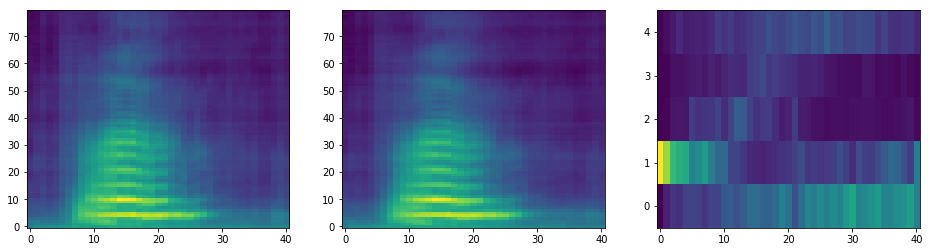

In [69]:
# mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
mel_outputs, mel_outputs_postnet, _, alignments = model.synthesizer.inference(sequence,
                                                                      latent_z, observed_z)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [70]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [59]:
sequence

tensor([[39, 58, 42, 51, 38, 56, 11, 57, 38, 55, 41, 42, 56,  7]],
       device='cuda:0')